# Data Preparation

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white' # Since I use a dark IDE

# To allow multiple outputs per cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [6]:
wba_data = pd.read_csv('wba_data_CLEAN.csv')
wba_data = wba_data.drop(["Unnamed: 0", "Subject"], axis=1)
wba_data.head()

,Gender,AgeY,PTA0.5,PTA1,PTA2,PTA4,PTAAv4FA,ECV,TPP,SC,...,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,0,9.333333,20,20,20,20,20,1.08,-189.0,0.52,...,-0.405697,-2.841202,1.594642,0.724436,-0.579289,-0.553364,0.704006,-0.409157,0.072477,-0.217327
1,0,9.500000,20,20,20,20,20,1.28,-49.0,1.28,...,1.479339,1.668937,-0.048483,0.608993,0.251156,-0.710949,0.604375,-0.616950,0.637559,-0.469144
2,1,9.833333,20,20,20,20,20,1.26,-27.0,0.87,...,-0.343253,-0.215469,-0.777275,-1.703650,0.510768,-0.413348,-0.206985,-0.375959,0.339409,-0.049631
3,0,9.916667,20,20,20,20,20,0.64,-8.0,0.60,...,-0.603940,1.065511,1.333238,0.796636,0.454654,-0.116502,0.247162,0.303749,-0.243954,-0.046242
4,0,7.916667,20,20,20,20,20,0.92,-17.0,1.65,...,-0.434886,2.172756,0.895713,1.079165,1.445886,0.345314,-1.758196,0.268712,-0.148645,-0.204201


## Removing Unwanted Variables

Removing PoF variables (updated in data_cleaning.py)

In [44]:
# features = list(wba_data.columns)
# print(len(features))

# for feature in wba_data.columns:
#     # print(feature)
#     if feature == "OverallPoF":
#         continue
#     elif feature[-3:] == "PoF":
#         print("Removing {}".format(feature))
#         features.remove(feature)
#     elif feature[-4:] == 'PoFC':
#         print("Removing {}".format(feature))
#         features.remove(feature)


# print(len(features))


153
Removing PTAAv4FAPoF
Removing PTAAv4FAPoFC
Removing TympPoF
Removing OAEPoF
Removing OAEPoFC
148


In [45]:
# print(features)

['Unnamed: 0', 'Subject', 'Gender', 'DOT', 'DOB', 'AgeM', 'AgeY', 'Ethnicity', 'PTA0.5', 'PTA1', 'PTA2', 'PTA4', 'PTAAv4FA', 'ECV', 'TPP', 'SC', 'TympType', 'OAE1', 'OAE1.4', 'OAE2', 'OAE2.8', 'OAE4', 'OverallPoF', 'EarSide', 'Ear coded', 'Pressure', 'f(226.0000)', 'f(257.3256)', 'f(280.6155)', 'f(297.3018)', 'f(324.2099)', 'f(343.4884)', 'f(363.9133)', 'f(385.5527)', 'f(408.4789)', 'f(432.7683)', 'f(458.5020)', 'f(471.9372)', 'f(500.0000)', 'f(514.6511)', 'f(545.2539)', 'f(561.2310)', 'f(577.6763)', 'f(594.6036)', 'f(629.9605)', 'f(648.4198)', 'f(667.4199)', 'f(686.9768)', 'f(707.1068)', 'f(727.8266)', 'f(749.1535)', 'f(771.1054)', 'f(793.7005)', 'f(816.9577)', 'f(840.8964)', 'f(865.5366)', 'f(890.8987)', 'f(917.0040)', 'f(943.8743)', 'f(971.5319)', 'f(1000.0000)', 'f(1029.3022)', 'f(1059.4631)', 'f(1090.5077)', 'f(1122.4620)', 'f(1155.3527)', 'f(1189.2071)', 'f(1224.0535)', 'f(1259.9210)', 'f(1296.8396)', 'f(1334.8399)', 'f(1373.9536)', 'f(1414.2136)', 'f(1455.6532)', 'f(1498.3071)',

In [7]:
features = list(wba_data.columns)

Removing PCAs:

In [8]:

for feature in wba_data.columns:
    if feature[:2] == "PC":
        print("Removing {}".format(feature))
        features.remove(feature)

# features

Removing PC1
Removing PC2
Removing PC3
Removing PC4
Removing PC5
Removing PC6
Removing PC7
Removing PC8
Removing PC9
Removing PC10
Removing PC11
Removing PC12
Removing PC13
Removing PC14
Removing PC15


In [47]:
#   Implemented in data_cleaning.py
#  unwanted_cols = ['Unnamed: 0', 'DOB', 'DOT', 'AgeM']

# for col in unwanted_cols:
#     print("Removing {}".format(col))
#     features.remove(col)

Removing Unnamed: 0
Removing DOB
Removing DOT
Removing AgeM


## Converting TympType to Numerical

Commented out - updated in data_cleaning.py

In [48]:
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder()

# ohe_tymptype = encoder.fit_transform(wba_data[['TympType']])

# print(ohe_tymptype.toarray()[1:10])

# ohe_tymptype = pd.DataFrame(ohe_tymptype)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [49]:
# wba_data['TympType'] = ohe_tymptype

## Train Test Split

Making list of all frequencies

In [12]:
freqs = [f for f in features if f[:2] == "f("]

In [13]:
y = wba_data['OverallPoF']

X = wba_data[freqs]
# X = X.loc[:, X.columns != 'OverallPoF']

# ### TEMPORARY
# X = X.loc[:, X.columns != 'TympType']
# X = X.loc[:, X.columns != 'EarSide']

# # X = X.drop(['Unnamed: 0', 'DOB', 'DOT', 'AgeM'], axis=1)
X.columns

Index(['f(226.0000)', 'f(257.3256)', 'f(280.6155)', 'f(297.3018)',
       'f(324.2099)', 'f(343.4884)', 'f(363.9133)', 'f(385.5527)',
       'f(408.4789)', 'f(432.7683)',
       ...
       'f(6168.8433)', 'f(6349.6042)', 'f(6535.6618)', 'f(6727.1713)',
       'f(6924.2925)', 'f(7127.1897)', 'f(7336.0323)', 'f(7550.9945)',
       'f(7772.2555)', 'f(8000.0000)'],
      dtype='object', length=107)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# Feature Selection


Creating dataframe with only frequencies and label column

In [50]:
wba_data_freqsonly = wba_data[freqs+["OverallPoF"]]

Creating function to visualise which frequencies are selected for each technique

In [159]:
def assess_freqs(wba_data, freq_cols, selected, title = "Selected Frequencies"):
    """
    wba_data: Full dataset
    freq_cols: List of all frequency column names
    selected: List of selected frequencies
    """

    # Creating melted dataframe (long format) for plotting
    overall_pof_df = wba_data[['OverallPoF'] + freq_cols]
    overall_pof_df = overall_pof_df.replace({'OverallPoF':{0: 'Pass', 1: 'Fail'}})
    overall_pof_df = overall_pof_df.groupby('OverallPoF').mean()
    overall_pof_df = overall_pof_df.melt(ignore_index=False)
    overall_pof_df = overall_pof_df.reset_index()

    # Plotting
    ax = sns.pointplot(x='variable', y='value', hue='OverallPoF', data=overall_pof_df)

    # Adding vertical lines at selected frequencies
    position = 0
    for freq in freq_cols:
        if freq in selected:
            ax.axvline(x=position, ls='--', color='red')
        position += 1

    sns.set(rc={'figure.figsize':(20,10)})

    # Rotate x-axis labels
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

    ax.set(title = title)

    # Show only every 2 tick labels on x-axis
    # plt.setp(ax.get_xticklabels()[::2], visible=False)

    plt.tight_layout()
    plt.show();



In [147]:
def assess_corrs(df, cols):
    corr_matrix_pca = df[cols].corr()

    sns.set(rc={'figure.figsize':(20,15)})
    sns.heatmap(corr_matrix_pca)

Example usage:

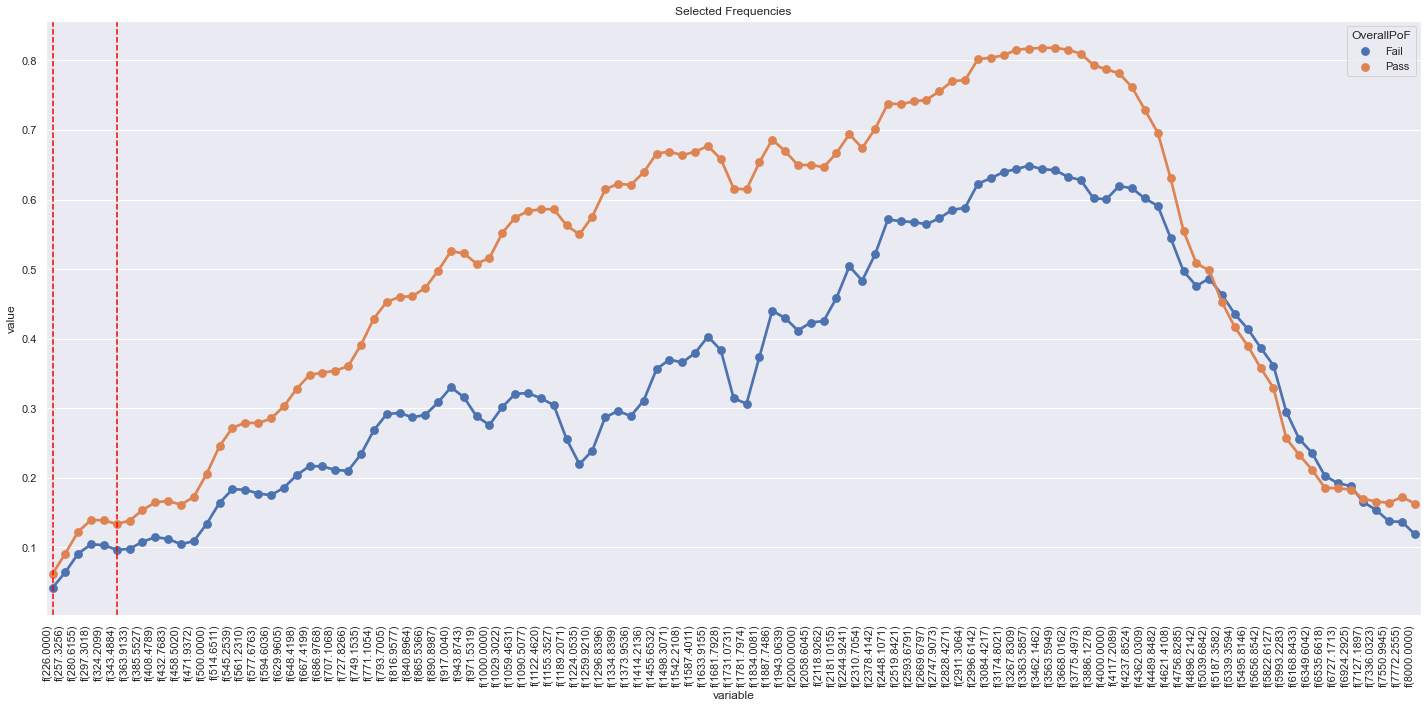

In [162]:
assess_freqs(wba_data, freqs, ['f(343.4884)', 'f(226.0000)'])

## Filter Methods

### Information gain

<AxesSubplot:>

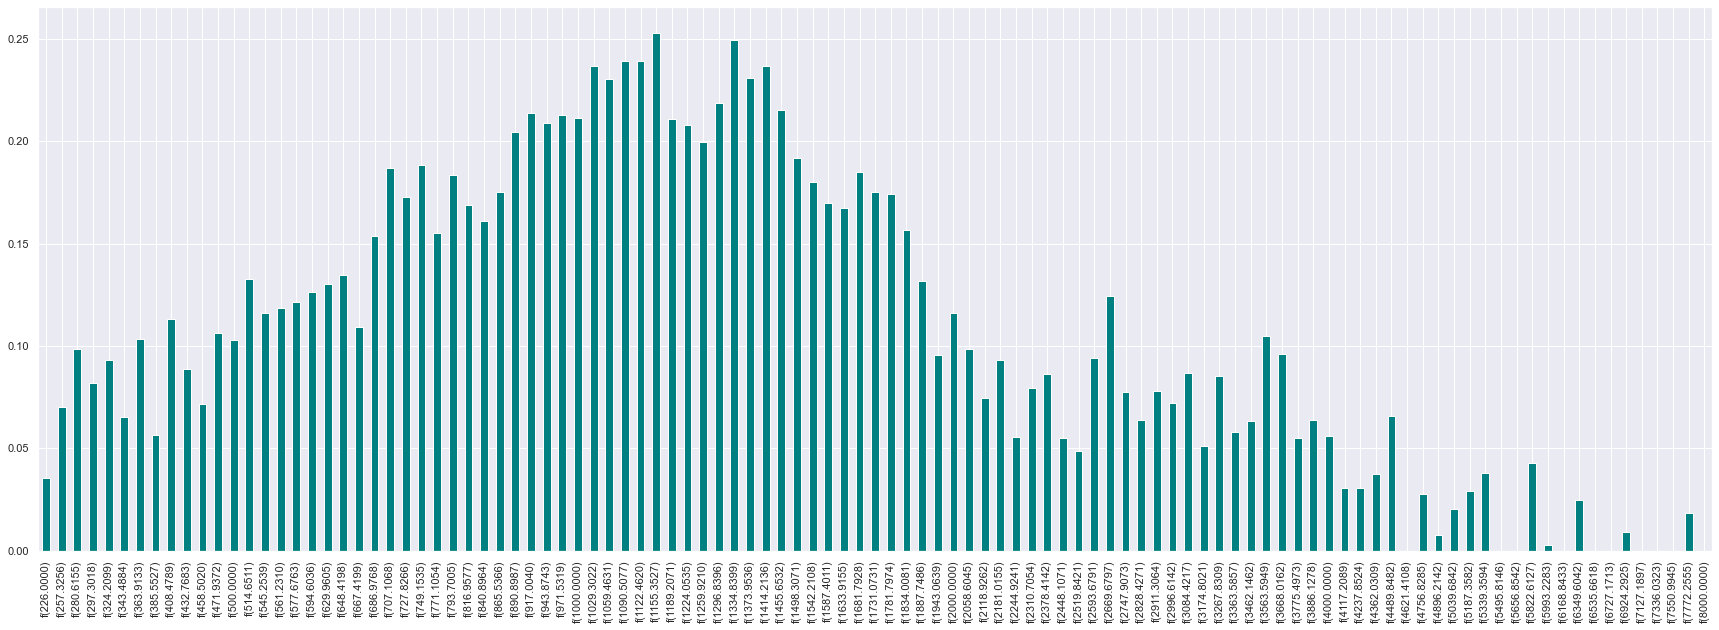

In [69]:
from sklearn.feature_selection import mutual_info_classif
from matplotlib.pyplot import figure

importances = mutual_info_classif(X, y)
feat_importances = pd.Series(importances, wba_data_freqsonly.columns[0:len(wba_data_freqsonly.columns)-1])
feat_importances.plot(kind='bar', color='teal')
plt.rcParams["figure.figsize"] = (40,10)
plt.show()


## Correlation Coefficient

In [99]:
cor = wba_data_freqsonly.corr()

corr_threshold = 0.5

# Correlation with predicted variable (deep copy as we will be editing `cor`)
cor_pred = cor['OverallPoF'].copy(deep=True)

abs(cor_pred) > 0.5

f(226.0000)     False
f(257.3256)     False
f(280.6155)     False
f(297.3018)     False
f(324.2099)     False
                ...  
f(7336.0323)    False
f(7550.9945)    False
f(7772.2555)    False
f(8000.0000)    False
OverallPoF       True
Name: OverallPoF, Length: 108, dtype: bool

### Variance Threshold

In [108]:
from sklearn.feature_selection import VarianceThreshold

v_threshold = VarianceThreshold(threshold=0.03)
v_threshold.fit(X)
v_threshold.get_support()

VarianceThreshold(threshold=0.03)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False,  True,  True,  True,  True, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False])

## Wrapper Methods

Methods that seach all possible feature subsets and assess their quality

### Forward Feature Selection

In [ ]:
# !pip install mlxtend

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    class_weight = "balanced",
    solver = "lbfgs",
    random_state=42,
    n_jobs = -1
)

ffs = SequentialFeatureSelector(lr, k_features = 'best', forward = True, n_jobs = -1)
ffs.fit(X, y)

In [144]:
features_ffs = list(ffs.k_feature_names_)

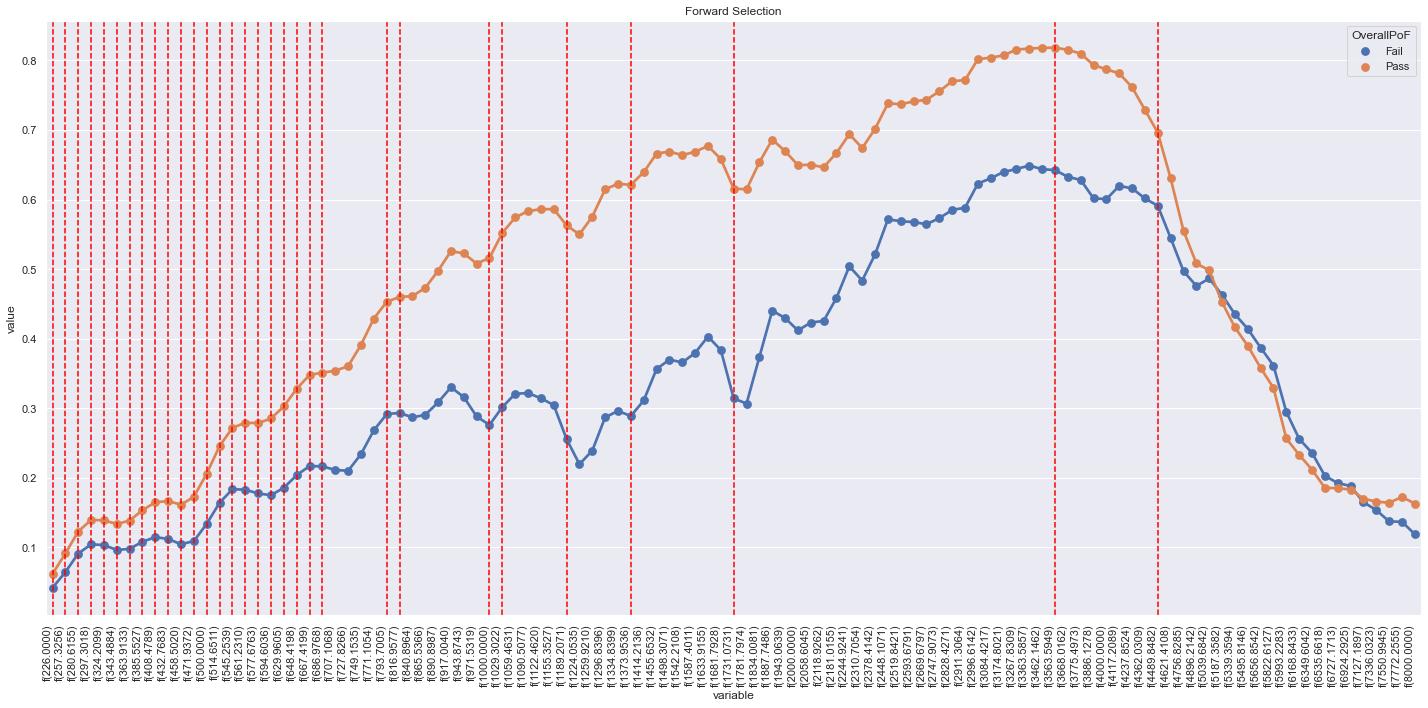

In [163]:
assess_freqs(wba_data, freqs, features_ffs, title="Forward Selection")

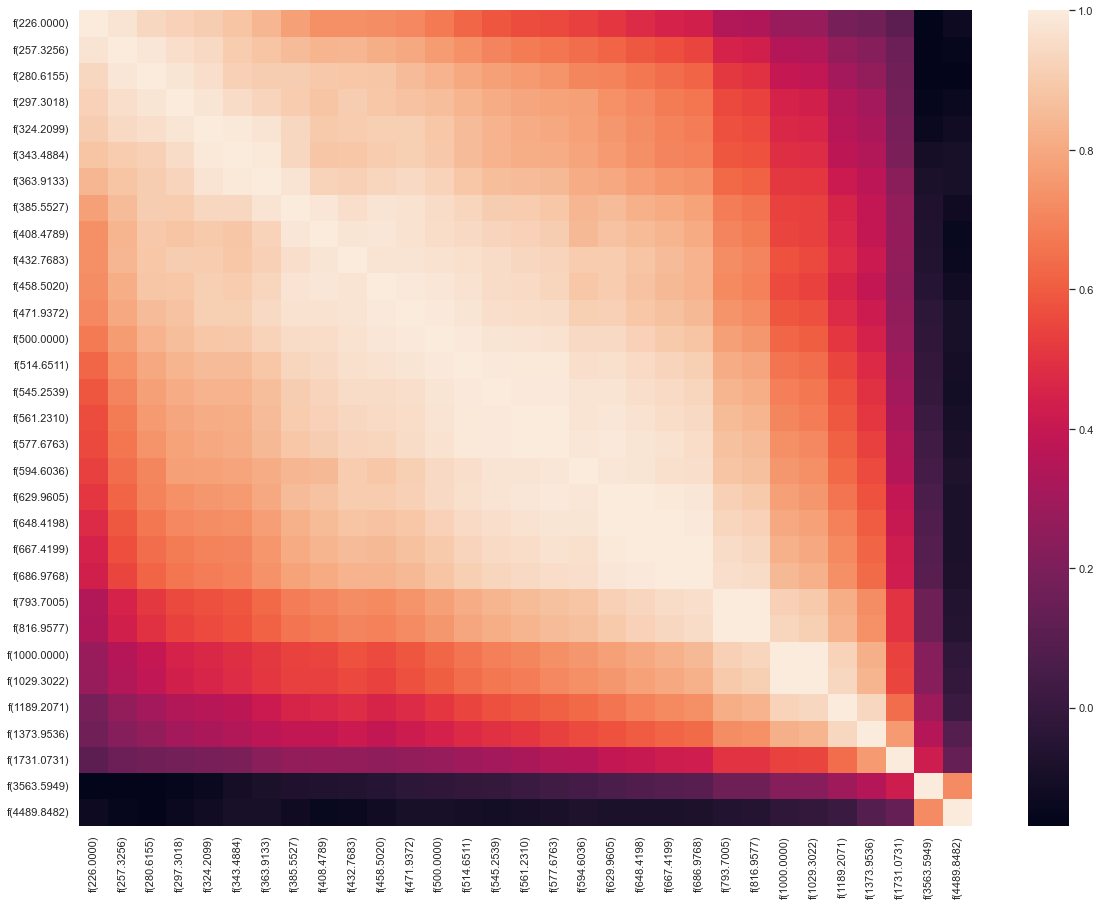

In [142]:
assess_corrs(wba_data, features_ffs)

### Backward Feature Elimination

In [ ]:
bfs = SequentialFeatureSelector(lr, k_features = 'best', forward = False, n_jobs = -1)
bfs.fit(X, y)

In [118]:
features_bfs = list(bfs.k_feature_names_)

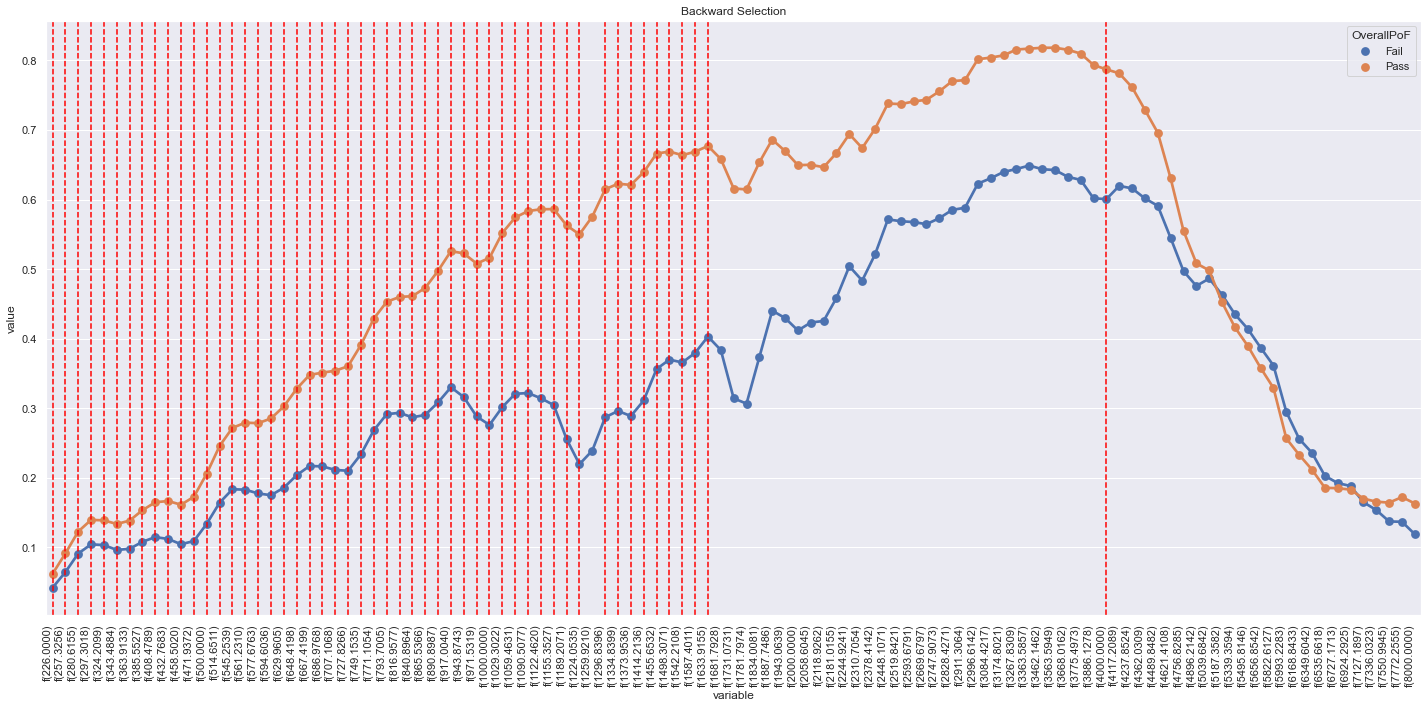

In [164]:
assess_freqs(wba_data, freqs, features_bfs, title="Backward Selection")

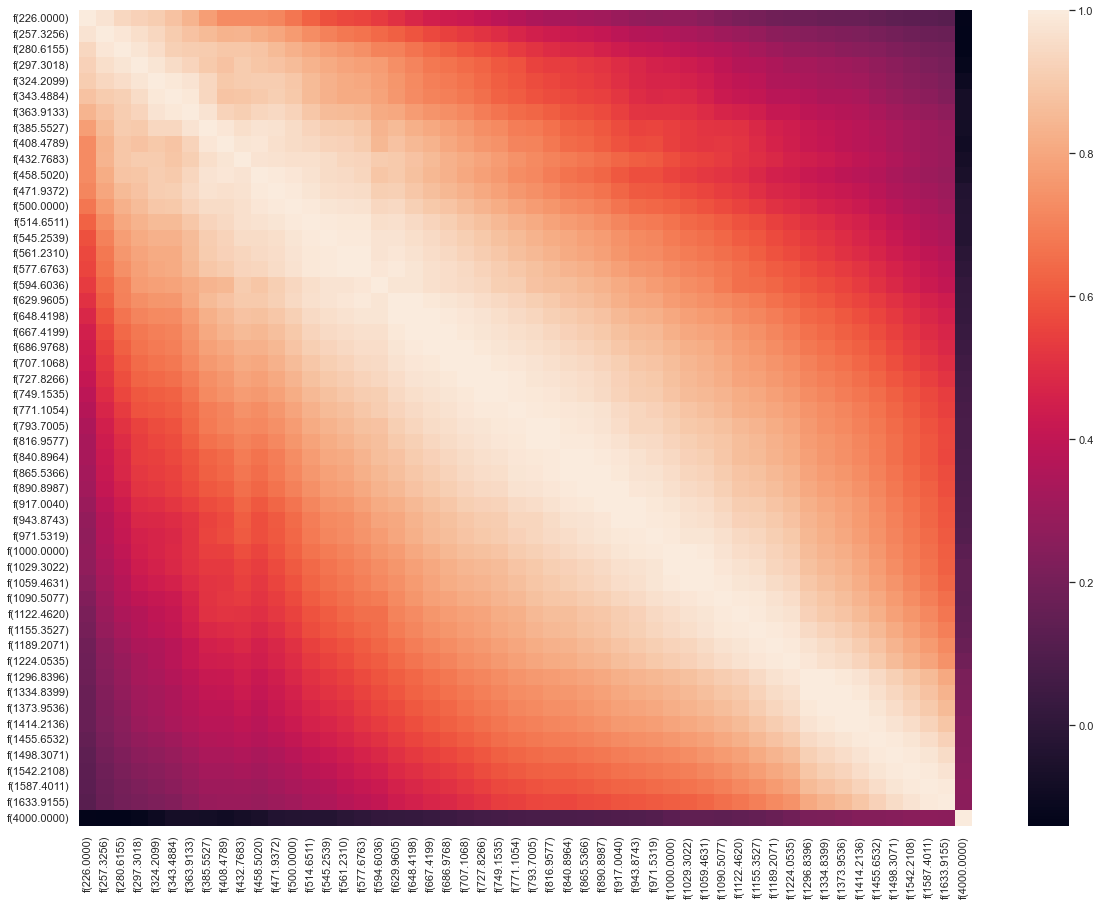

In [140]:
assess_corrs(wba_data, features_bfs)

## Random Forest

In [165]:
feature_select = SelectFromModel(
    RandomForestClassifier(n_estimators = 200)
    )

feature_select.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=200))

In [166]:
feature_select.get_params(deep=True)

{'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 200,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(n_estimators=200),
 'importance_getter': 'auto',
 'max_features': None,
 'norm_order': 1,
 'prefit': False,
 'threshold': None}

In [167]:
imp_indices = feature_select.get_support(indices=True)
print(imp_indices)

imp = []

for i in imp_indices:
    imp.append(X.columns[i])
print(imp)

[22 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50]
['f(707.1068)', 'f(943.8743)', 'f(971.5319)', 'f(1000.0000)', 'f(1029.3022)', 'f(1059.4631)', 'f(1090.5077)', 'f(1122.4620)', 'f(1155.3527)', 'f(1189.2071)', 'f(1224.0535)', 'f(1259.9210)', 'f(1296.8396)', 'f(1334.8399)', 'f(1373.9536)', 'f(1414.2136)', 'f(1455.6532)', 'f(1498.3071)', 'f(1542.2108)', 'f(1587.4011)']


In [168]:
important = feature_select.get_support()

In [170]:
features_rf = X.columns[important]

In [77]:
selected_feat= X_train.columns[(feature_select.get_support())]
len(selected_feat)

32

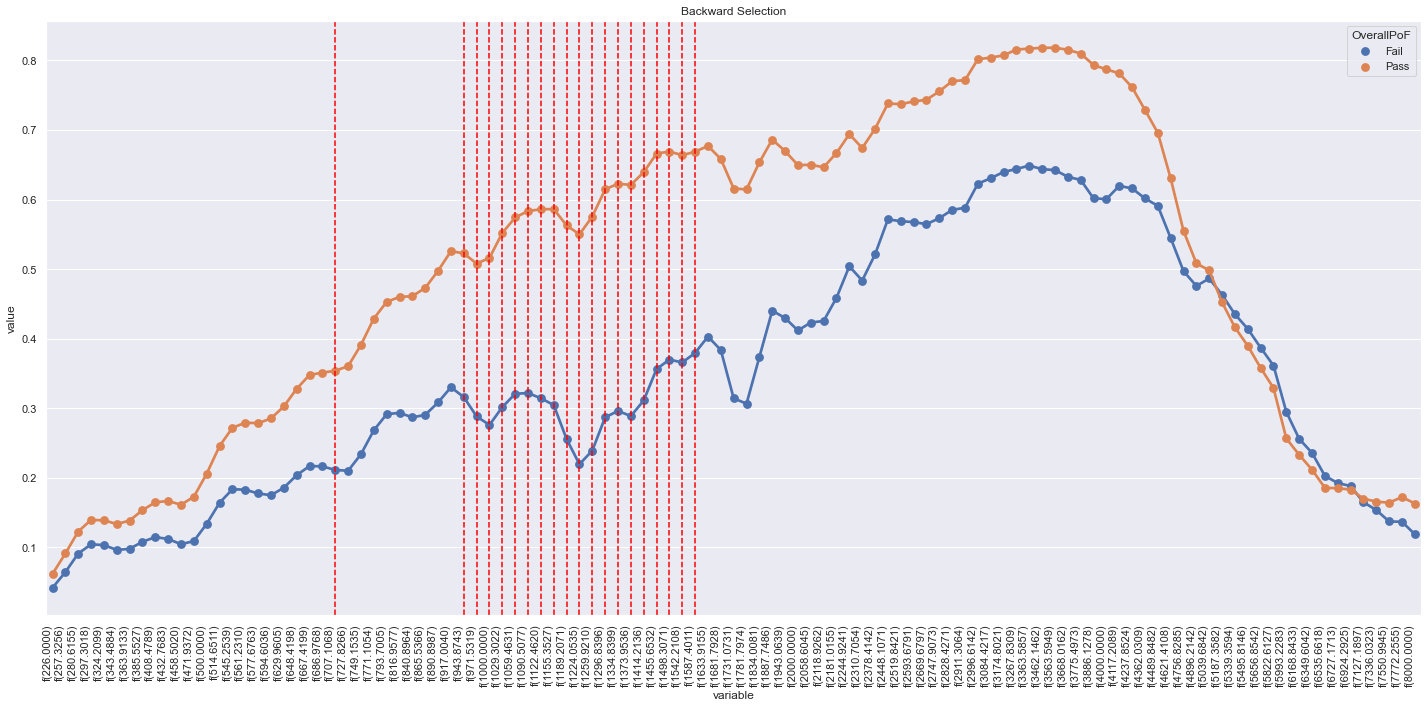

In [171]:
assess_freqs(wba_data, freqs, features_rf, title="Backward Selection")